In [190]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import maup
from zipfile import ZipFile
import numpy as np
import os
import shutil

# US Senate

In [191]:
#Read in election results
#unzip all county shapefiles
#read in all county shapefiles
#concatenate all files (same fields should keep it simple) - use a dictionary?

### Final File - Load

In [196]:
#Check out final file: https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/UBKYRU/FQDLOO&version=33.0 
final = gpd.read_file('./vest_va/va_2018_senate/va_2018_senate.shp')

In [197]:
final.head() #	G18USSOWRI = "Write-in Votes" from vest documentation

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry
0,001,Accomack County,000101,Chincoteague,556,994,17,0,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42..."
1,001,Accomack County,000201,Atlantic,182,459,11,0,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59..."
2,001,Accomack County,000202,Greenbackville,316,577,8,1,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49..."
3,001,Accomack County,000301,New Church,588,477,11,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64..."
4,001,Accomack County,000401,Bloxom,121,277,4,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71..."


# Election Results: US Senate 

In [198]:
#US senate results from the state: https://historical.elections.virginia.gov/elections/view/134055/ 
df = pd.read_csv('./vest_va/Virginia_Elections_Database__2018_U_S_Senate_General_Election_including_precincts.csv')

- Election race/Candidate name format change to match VEST
- precinct identifier change to match

In [199]:
df.head() #Ward not appearing, should it?

,County/City,Ward,Pct,Timothy Michael Kaine,Corey Alan Stewart,Matthew Joseph Waters,All Others,Total Votes Cast
0,NaN,NaN,NaN,Democratic,Republican,Libertarian,NaN,NaN
1,Accomack County,-,101 - Chincoteague,487,932,16,0,"1,435"
2,Accomack County,-,201 - Atlantic,159,430,10,0,599
3,Accomack County,-,202 - Greenbackville,277,541,7,1,826
4,Accomack County,-,301 - New Church,515,447,10,0,972


## Figure out overlap and rename accordingly to match final file

**From shp**, want columns: ['COUNTYFP', 'VTDST', 'geometry']

**From df**, want columns: ['Count/City'] adapted to match ['LOCALITY'], ['Pct'] adapted to ['PRECINCT'], all election/candidate/race formats match final

In [202]:
set(df['County/City']) - set(final['LOCALITY']) #account for totals later

{'TOTALS', nan}

RENAME COLUMNS BUT NO CONTENT CHANGE

In [203]:
df['LOCALITY'] = df['County/City']
df['G18USSDKAI'] = df['Timothy Michael Kaine']
df['G18USSRSTE'] = df['Corey Alan Stewart']
df['G18USSLWAT'] = df['Matthew Joseph Waters']
df['G18USSOWRI'] = df['All Others']
df = df.iloc[1:]
df = df.drop(['County/City', 'Ward', 'Timothy Michael Kaine', 'Corey Alan Stewart', 'Matthew Joseph Waters', 'All Others', 'Total Votes Cast'], axis = 1)
df.head()

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI
1,101 - Chincoteague,Accomack County,487,932,16,0
2,201 - Atlantic,Accomack County,159,430,10,0
3,202 - Greenbackville,Accomack County,277,541,7,1
4,301 - New Church,Accomack County,515,447,10,0
5,401 - Bloxom,Accomack County,106,260,4,0


In [24]:
(final['LOCALITY'] + final['VTDST'].str.slice(start = 3)).nunique()

2441

While the first three digits of `VTDST` are not always 0, locality combined with the last three of that code still has the same number of unique values.

## Look into merges

Peter noted that these were likely geometry changes that we will not worry about. Instead, need to focus on re-allocating votes.

In [204]:
# 'Albemarle: Add Mechums River to match county GIS shapefile'
df[df['LOCALITY'].map(lambda x: 'Albemarle' in str(x)) & df['Pct'].map(lambda x: 'Mechums' in str(x))]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI
48,606 - Mechums River,Albemarle County,"1,426",695,61,4


In [205]:
# 'Arlington: Adjust Gunston/Oakridge to match county GIS shapefile'
df[(df['LOCALITY'].map(lambda x: 'Arlington' in str(x)) & df['Pct'].map(lambda x: 'Gunston' in str(x)))] 

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI
177,52 - Gunston,Arlington County,"1,092",193,41,8


In [206]:
final[(final['LOCALITY'].map(lambda x: 'Arlington' in str(x)) & final['PRECINCT'].map(lambda x: 'Gunston' in str(x)))]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry
2418,013,Arlington County,000052,Gunston,1375,224,47,9,"POLYGON Z ((-77.08225 38.84343 0.00000, -77.08..."


In [31]:
df[(df['LOCALITY'].map(lambda x: 'Arlington' in str(x)) & df['Pct'].map(lambda x: 'Oakridge' in str(x)))]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI
157,32 - Oakridge,Arlington County,577,179,21,4


In [207]:
county_dict = pd.Series(final['COUNTYFP'].values, index = final['LOCALITY']).to_dict()
df['COUNTYFP'] = df['LOCALITY'].map(county_dict)

In [208]:
df.loc[:,'G18USSDKAI'] = df['G18USSDKAI'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSRSTE'] = df['G18USSRSTE'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSLWAT'] = df['G18USSLWAT'].map(lambda x: x.replace(',', ''))
df.loc[:,'G18USSOWRI'] = df['G18USSOWRI'].map(lambda x: x.replace(',', ''))
#added .loc to account for "copy" warning
df['G18USSDKAI'] = df['G18USSDKAI'].astype(str).astype(int)
df['G18USSRSTE'] = df['G18USSRSTE'].astype(str).astype(int)
df['G18USSLWAT'] = df['G18USSLWAT'].astype(str).astype(int)
df['G18USSOWRI'] = df['G18USSOWRI'].astype(str).astype(int)

In [210]:
groupby_county_df = df.groupby('COUNTYFP').sum()
groupby_county_final = final.groupby(['COUNTYFP']).sum()

,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI
COUNTYFP,,,,
001,5997,6605,135,8
003,35701,16371,1161,93
005,1952,3433,66,2
007,1938,3823,81,7
009,4541,7779,215,10
...,...,...,...,...
800,21397,13397,461,37
810,91813,73575,3851,204
820,3849,3713,149,7


In [212]:
column_list = ['G18USSDKAI', 'G18USSRSTE', 'G18USSLWAT', 'G18USSOWRI']

In [213]:
df_final_groupby = pd.merge(groupby_county_df, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))

In [214]:
df_final_groupby.head()

,G18USSDKAI_x,G18USSRSTE_x,G18USSLWAT_x,G18USSOWRI_x,G18USSDKAI_y,G18USSRSTE_y,G18USSLWAT_y,G18USSOWRI_y
COUNTYFP,,,,,,,,
001,5997,6605,135,8,5997,6605,135,8
003,35701,16371,1161,93,35701,16371,1161,93
005,1952,3433,66,2,1952,3433,66,2
007,1938,3823,81,7,1938,3823,81,7
009,4541,7779,215,10,4541,7779,215,10


In [215]:
def sum_checker(df, column_list):
    list_max = 0
    for i in column_list:
        left_sum = df[i+'_x'].sum()
        right_sum = df[i+'_y'].sum()
        if (left_sum == right_sum):
            print('column: ', i, ' have the same sums')
        
        else:
            diff = abs(left_sum - right_sum)
            percent = abs(left_sum - right_sum)/left_sum
            print('column: ', i)
            print('RDH sum is ', str(left_sum))
            print('Partner sum is ', str(right_sum))
            print('their (absolute) difference is ', str(diff))
            print('As a percentage of DF1 this is ', str(round(percent*100,5)) + '%')
            if (percent>list_max):
                list_max = percent
            print('')
    print('The max difference (as a percent of the total of on DF column is: ', str(round(list_max,5)))

In [216]:
sum_checker(df_final_groupby, column_list)

column:  G18USSDKAI  have the same sums
column:  G18USSRSTE  have the same sums
column:  G18USSLWAT  have the same sums
column:  G18USSOWRI  have the same sums
The max difference (as a percent of the total of on DF column is:  0


**By county, results match** (great!)
Now need to re-allocate votes so that it matches by precinct

First think about for single county single candidate
- tricky thing is rounding - need to update sum checker to be tolerant of rounding
- fact that exactly the right number of votes indicates not a consistent rounding method
- I can just pick a rounding thing now - pick it and move forward - 

In [217]:
def get_absentee_frac(prec_tot, county_tot, absentee_tot):
    '''A spec specifies in first line what function will do
    Returns fraction of county absentee votes for a precinct for a candidate
    
    Keyword arguments: (put inputs to funtions and say what they should be)
    precinct vote total for given candidate (int)
    county vote total for given candidate, absentee and provisional votes not included (int)
    absentee vote total for county for given candidate (int)
    
    "Pure function" bc only relies on inputs and outputs - only variables are ones that were passed as arguments
    '''
    if county_tot != 0:
        prec_frac = prec_tot/county_tot
        absentee_frac = prec_frac*absentee_tot
    else:
        absentee_frac = 0
    return absentee_frac

In [218]:
absentee_and_prov = df[(df['Pct'].map(lambda x: 'Absentee' in str(x))) | (df['Pct'].map(lambda x: 'Provisional' in str(x)))]
groupby_absentee_and_prov_tot = absentee_and_prov.groupby(['COUNTYFP']).sum()
groupby_county_df_tot = df.groupby(['COUNTYFP']).sum()
df_no_absent_or_provisional = df[(df['Pct'].map(lambda x: 'Absentee' not in str(x))) & (df['Pct'].map(lambda x: 'Provisional' not in str(x)))
                                & (df['LOCALITY'] != 'TOTALS')]
groupby_county_tot_no_absentee = df_no_absent_or_provisional.groupby('COUNTYFP').sum()

In [238]:
#4/2/21
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
for index, precinct_total_row_by_candidate in df_no_absent_or_provisional.iterrows():
    #print(precinct_total_row_by_candidate)
    county_fips = precinct_total_row_by_candidate['COUNTYFP']
    county_total_row_by_candidate_no_absentee = groupby_county_tot_no_absentee.loc[county_fips]
    county_absentee_and_provisional_by_candidate = groupby_absentee_and_prov_tot.loc[county_fips]
    #print(precinct_total_row_by_candidate, county_total_row_by_candidate_no_absentee, county_absentee_and_provisional_by_candidate)
    for candidate, votes in county_total_row_by_candidate_no_absentee.to_dict().items():
        prec_tot = precinct_total_row_by_candidate[candidate]
        #print('precinct total: ', prec_tot)
        county_tot = votes
        #print('county total: ', county_tot)
        absentee_tot = county_absentee_and_provisional_by_candidate[candidate]
        #print('absentee total: ', absentee_tot)
        absentee_frac = get_absentee_frac(prec_tot, county_tot, absentee_tot)
        #print('absentee votes to allocate to precinct: ', absentee_frac)
        prec_with_absentee_allocation = prec_tot + absentee_frac
        #print('new precinct total: ', prec_with_absentee_allocation)
        df_with_absentee_reallocated.loc[index, candidate] = prec_with_absentee_allocation #index is row, candidate is column

   

In [239]:
groupby_df_with_absentee_reallocated = df_with_absentee_reallocated.groupby('COUNTYFP').sum()

In [240]:
df_absentee_reallocate_with_final = pd.merge(groupby_df_with_absentee_reallocated, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))

In [241]:
df_absentee_reallocate_with_final

,G18USSDKAI_x,G18USSRSTE_x,G18USSLWAT_x,G18USSOWRI_x,G18USSDKAI_y,G18USSRSTE_y,G18USSLWAT_y,G18USSOWRI_y
COUNTYFP,,,,,,,,
001,5997.0,6605.0,135.0,8.0,5997,6605,135,8
003,35701.0,16371.0,1161.0,93.0,35701,16371,1161,93
005,1952.0,3433.0,66.0,2.0,1952,3433,66,2
007,1938.0,3823.0,81.0,7.0,1938,3823,81,7
009,4541.0,7779.0,215.0,10.0,4541,7779,215,10
...,...,...,...,...,...,...,...,...
800,21397.0,13397.0,461.0,37.0,21397,13397,461,37
810,91813.0,73575.0,3851.0,204.0,91813,73575,3851,204
820,3849.0,3713.0,149.0,7.0,3849,3713,149,7


In [242]:
sum_checker(df_absentee_reallocate_with_final, column_list)

column:  G18USSDKAI
RDH sum is  1910369.9999999998
Partner sum is  1910370
their (absolute) difference is  2.3283064365386963e-10
As a percentage of DF1 this is  0.0%

column:  G18USSRSTE  have the same sums
column:  G18USSLWAT  have the same sums
column:  G18USSOWRI
RDH sum is  5506.999999999998
Partner sum is  5509
their (absolute) difference is  2.000000000001819
As a percentage of DF1 this is  0.03632%

The max difference (as a percent of the total of on DF column is:  0.00036


^ with no rounding

In [234]:
#4/2/21
df_with_absentee_reallocated = df_no_absent_or_provisional.copy()
for index, precinct_total_row_by_candidate in df_no_absent_or_provisional.iterrows():
    #print(precinct_total_row_by_candidate)
    county_fips = precinct_total_row_by_candidate['COUNTYFP']
    county_total_row_by_candidate_no_absentee = groupby_county_tot_no_absentee.loc[county_fips]
    county_absentee_and_provisional_by_candidate = groupby_absentee_and_prov_tot.loc[county_fips]
    #print(precinct_total_row_by_candidate, county_total_row_by_candidate_no_absentee, county_absentee_and_provisional_by_candidate)
    for candidate, votes in county_total_row_by_candidate_no_absentee.to_dict().items():
        prec_tot = precinct_total_row_by_candidate[candidate]
        #print('precinct total: ', prec_tot)
        county_tot = votes
        #print('county total: ', county_tot)
        absentee_tot = county_absentee_and_provisional_by_candidate[candidate]
        #print('absentee total: ', absentee_tot)
        absentee_frac = get_absentee_frac(prec_tot, county_tot, absentee_tot)
        #print('absentee votes to allocate to precinct: ', absentee_frac)
        prec_with_absentee_allocation = prec_tot + absentee_frac
        #print('new precinct total: ', prec_with_absentee_allocation)
        df_with_absentee_reallocated.loc[index, candidate] = round(prec_with_absentee_allocation) #index is row, candidate is column

   

In [235]:
groupby_df_with_absentee_reallocated = df_with_absentee_reallocated.groupby('COUNTYFP').sum()

In [236]:
df_absentee_reallocate_with_final = pd.merge(groupby_df_with_absentee_reallocated, groupby_county_final, on = 'COUNTYFP', how = 'inner', suffixes = ('_x', '_y'))

In [237]:
sum_checker(df_absentee_reallocate_with_final, column_list)

column:  G18USSDKAI  have the same sums
column:  G18USSRSTE
RDH sum is  1374310.0
Partner sum is  1374313
their (absolute) difference is  3.0
As a percentage of DF1 this is  0.00022%

column:  G18USSLWAT
RDH sum is  61503.0
Partner sum is  61565
their (absolute) difference is  62.0
As a percentage of DF1 this is  0.10081%

column:  G18USSOWRI
RDH sum is  5361.0
Partner sum is  5509
their (absolute) difference is  148.0
As a percentage of DF1 this is  2.76068%

The max difference (as a percent of the total of on DF column is:  0.02761


With rounding^ totals much worse

Good totals, but inconsistent rounding in final file in cases where vote total has more than 0.5 and less than 0.7

### @ Peter
- how did they round? - by county totals? - Peter rounded to nearest whole number, was fine with things that were 2 votes off for purposes of report

### From meeting with Spencer:

Address geographies before joining with election results
can clean election results, but need it all to match first
"Adjust" might not matter for joining election results, but the geometries would be wrong
if not splitting or merging , could check first

How many precincts in gdf, how many in vest final file?


Assume that changes are for all of the files, but for senate legislative districts arent applicaple
but still need to make modifications for precincts to match

Need sldl and cd from county files as well - pull legislative boundaries from the census to split them 
tigerline - didnt list all county shapfiles - use 2018 file 

for special election, sldl should be fine, just pull out district 8 and 24
does the special file have whole state or just those two districts

number VTDs from vest and from downloaded files

# Shapefiles: County

## Load, Project

In [78]:
#All counties found: https://www.census.gov/geo/partnerships/pvs/partnership19v2/st51_va.html <-- careful, need to pay close attention to url to makesure get vtds
os.listdir('./vest_va/census_shps_by_county_all_unzip/')

['partnership_shapefiles_19v2_51580',
 'partnership_shapefiles_19v2_51117',
 'partnership_shapefiles_19v2_51121',
 'partnership_shapefiles_19v2_51119',
 'partnership_shapefiles_19v2_51770',
 'partnership_shapefiles_19v2_51181',
 'partnership_shapefiles_19v2_51175',
 'partnership_shapefiles_19v2_51143',
 'partnership_shapefiles_19v2_51520',
 'partnership_shapefiles_19v2_51127',
 'partnership_shapefiles_19v2_51740',
 'partnership_shapefiles_19v2_51111',
 'partnership_shapefiles_19v2_51145',
 'partnership_shapefiles_19v2_51510',
 'partnership_shapefiles_19v2_51187',
 'partnership_shapefiles_19v2_51173',
 'partnership_shapefiles_19v2_51001',
 'partnership_shapefiles_19v2_51650',
 '.DS_Store',
 'partnership_shapefiles_19v2_51037',
 'partnership_shapefiles_19v2_51063',
 'partnership_shapefiles_19v2_51097',
 'partnership_shapefiles_19v2_51099',
 'partnership_shapefiles_19v2_51009',
 'partnership_shapefiles_19v2_51660',
 'partnership_shapefiles_19v2_51036',
 'partnership_shapefiles_19v2_51031'

In [79]:
#unzip file function
def unzip(path, src_path, dest_path, zip_file_name, unzipped_file_name):
    os.chdir(path)
    with ZipFile(zip_file_name, 'r') as zipObj:
        zipObj.extractall(unzipped_file_name) 
        
    shutil.move(src_path, dest_path)

In [80]:
#unzip multiple files in directory
def unzip_mult_files(path, new_dir_path):
    if not path[0] == '.':
        os.chdir(path)
        for zipfile in os.listdir():
            if not zipfile[0] == '.' and not zipfile == 'partnership_shapefiles_19v2_51.zip':
                if zipfile.endswith('.zip'): 
                    unzipped_file_name = zipfile[:-4]
                    src_path = os.path.join(path, unzipped_file_name)
                    dest_path = new_dir_path #os.path.join(new_dir_path, unzipped_file_name)
                    unzip(path, src_path, dest_path, zipfile, unzipped_file_name)
                    
'''#test out mult file function - I think it is working - I think embedded folders is product of re-zipping folder?
path = ('/Users/lilyfalk/sandbox/pdv-va/vest_va/test_dir1/')
new_dir_path = '/Users/lilyfalk/sandbox/pdv-va/vest_va/test_dir'
unzip_mult_files(path, new_dir_path)'''

"#test out mult file function - I think it is working - I think embedded folders is product of re-zipping folder?\npath = ('/Users/lilyfalk/sandbox/pdv-va/vest_va/test_dir1/')\nnew_dir_path = '/Users/lilyfalk/sandbox/pdv-va/vest_va/test_dir'\nunzip_mult_files(path, new_dir_path)"

In [ ]:
#unzip files in multiple directories
def unzip_in_mult_directories(path, new_dir_path):
    os.chdir(path)
    for directory in os.listdir():
        if not directory[0] == '.':
            sub_dir = os.path.join(path, directory)
            unzip_mult_files(sub_dir, new_dir_path)
            os.chdir(path)
            
'''
path = '/Users/lilyfalk/sandbox/pdv-va/vest_va/census_shps_by_county_dir_unzip/'
new_dir_path = '/Users/lilyfalk/sandbox/pdv-va/vest_va/census_shps_by_county_all_unzip'
unzip_in_mult_directories(path, new_dir_path)'''

Now consider how to read in all vtd shapefiles:
naming convention ex: 'PVS_19_v2_vtd_51650.shp'
directory convention: 'partnership_shapefiles_19v2_51650"

So, for directory in os.listdir(), read in 'PVS_19_v2_vtd_' + directory[-5:] + '.shp'
then concatenate all of the files read in, maybe add to dictionary first

In [81]:
path = ('/Users/lilyfalk/sandbox/pdv-va/vest_va/census_shps_by_county_all_unzip/')
os.chdir(path)
county_fips = []
for directory in os.listdir():
    if not directory[0] == '.':
        county_fips.append(directory[-5:])

In [82]:
len(county_fips) #As expected

133

In [83]:
proj = final.crs

In [84]:
#Now need function that will read in and concatenate all VTD shapefiles
#Note that last 5 digits of directory and file are state fip (51) plus county fip (3-digit)
path = ('/Users/lilyfalk/sandbox/pdv-va/vest_va/census_shps_by_county_all_unzip/')
os.chdir(path)
county_vtds = []

for i in county_fips: #i dont have fips_codes file
    ref = 'partnership_shapefiles_19v2_'
    vtd_ref = ref + i + '/PVS_19_v2_vtd_' + i + '.shp' 
    vtd_shp = gpd.read_file(vtd_ref)
    print(i, ' added to list')
    county_vtds.append(vtd_shp)

51580  added to list
51117  added to list
51121  added to list
51119  added to list
51770  added to list
51181  added to list
51175  added to list
51143  added to list
51520  added to list
51127  added to list
51740  added to list
51111  added to list
51145  added to list
51510  added to list
51187  added to list
51173  added to list
51001  added to list
51650  added to list
51037  added to list
51063  added to list
51097  added to list
51099  added to list
51009  added to list
51660  added to list
51036  added to list
51031  added to list
51007  added to list
51053  added to list
51065  added to list
51091  added to list
51047  added to list
51071  added to list
51085  added to list
51049  added to list
51620  added to list
51680  added to list
51025  added to list
51013  added to list
51810  added to list
51077  added to list
51083  added to list
51079  added to list
51610  added to list
51041  added to list
51015  added to list
51023  added to list
51820  added to list
51169  added 

In [85]:
global shapefiles_census
shapefiles_census = gpd.GeoDataFrame(pd.concat(county_vtds, axis = 0) , crs = proj) 

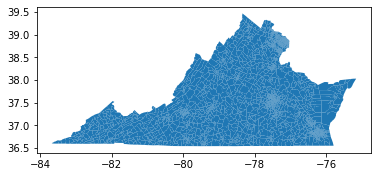

In [86]:
shapefiles_census.plot()

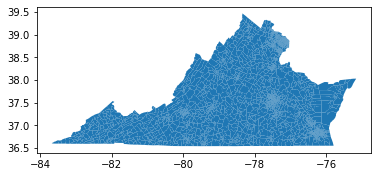

In [87]:
final.plot()

## Dealing with merges 

**From VEST documentation: -- Are these changes to the election result precincts, not to the map?**

The following modifications were made to recreate the 2018 precinct boundaries.

- Albemarle: Add Mechums River to match county GIS shapefile
- Arlington: Adjust Gunston/Oakridge to match county GIS shapefile
- Bristol City: Adjust Ward 2/Ward 4 to match description in municipal code
- Charles City County: Adjust District 1/District 2 boundary to match county code
- Covington City: Realign Ward 1, Ward 2, Ward 3 to match city PDF map and municipal code
- Culpeper: Adjust East Fairfax/Brandy Station boundary to match county GIS shapefile
- Emporia City: Adjust Precincts 1/7, Precincts 2/5 to match municipal code
- Essex: Adjust South Precinct/Central Precinct boundary to match county PDF
- Fairfax: Adjust Virginia Run/Bull Run to match county GIS shapefile
- Fredericksburg City: Adjust District 1/3 boundaries to match municipal code
- Galax City: Adjust North/South precinct boundary to match municipal GIS shapefile
- Goochland: Adjust Hadensville/Fife boundary to match description in county code
- Halifax: Merge South Boston East/West; Adjust Meadville/Republican Grove to match 2011 redistricting PDF map
- Hampton City: Add US House District 2 segment of Tyler Precinct to match county PDF
- Hanover: Adjust Blunts/Beaverdam boundary to match county PDF
- Henry: Adjust 10 precinct boundaries to align VTDs with county GIS shapefile
- Loudoun: Adjust Weller/Ashbrook, Evergreen/Sycolin Creek; Add Goshen Post, Buffalo Trail to match county GIS shapefile
- Madison: Adjust all precincts to align VTDs with county GIS shapefile
- Newport News City: Adjust Sanford/Riverview boundary to match county GIS shapefile
- Norfolk City: Merge Bramblewood into Chesterfield/Ruffner Academy; Adjust Granby/Titustown to match county PDF
- Prince William: Adjust Ben Lomond/Mullen, Freedom/Leesylvania to match county GIS shapefile
- Pulaski: Adjust Dublin/New River to match precinct assignments on county GIS parcel viewer
- Rappahanock: Adjust Sperryville/Washington boundary to match county PDF
- Richmond City: Add Precinct 115 to match county GIS shapefile
- Richmond County: Adjust Precincts 2-1/3-1 boundary to match description in county ordinance
- Roanoke County: Adjust 12 precinct boundaries to match county GIS shapefile
- Rockingham: Split East/West Bridgewater to match municipal ordinance; Adjust East Bridgewater to match municipal boundary
- Russell: Adjust Daugherty/West Lebanon boundary to match county PDF
- Tazewell: Merge Abbs Valley/Bossevain, Adria/Gap Store, Pounding Mill/Wardell, Raven/Richlands;  Adjust nearly all precinct boundaries to align VTDs with county GIS shapefile
- Virginia Beach City: Adjust Centerville/Colonial to match county GIS shapefile
- Williamsburg City: Revise Matoaka/Stryker to match municipal PDF map and municipal code
- Wise: Adjust Big Stone Gap/East Stone Gap boundary to match county GIS shapefile
- Wythe: Adjust West Wytheville/East Wytheville boundary to match county GIS shapefile

In [245]:
shp = shapefiles_census

In [246]:
shp.shape

(2462, 17)

In [247]:
final.shape #Great that they are close!   

(2463, 9)

In [248]:
df_with_absentee_reallocated.shape

(2462, 7)

### Next step - now that df and final data row counts match more closely
- need to create unique identifier to match shp, then merge + check geographies...
  - should I just join shp and df to final file, not worry about unique ID?

Using below method, see that in df, 
- some first characters are getting cut off (ex:'74017 ICTORY LIFE FELLOWSHIP' vs  '740017VICTORY LIFE FELLOWSHIP')
- inconsistent # of number characters 
- DF some precincts have (CD #) whereas final file does not have this at all
- some precincts (GLEN FOREST) in DF, not in final and not noted in documentation

In [249]:
(df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.Pct.str.slice(stop = 3)).value_counts()

800404    2
153312    2
095202    2
55020     2
177402    2
         ..
087407    1
171601    1
089401    1
0133 -    1
087507    1
Length: 2440, dtype: int64

Peter + Izzy 4/6/21
- import congressional shapefiles, assign the overlap as the new shapefile
- create list of vtds where not unique
- join ones that do work with county and vtdst
    - print out ones that dont match and manually match them up
    - right now in election and shapefile could create column with county fip, vtdst 
    filter out ones that repeat entirely
    remaining ones join manually in mini df
    then join the two dfs - could create a dictionary to map from nonunique to temporary unique one - adding a or b to end of it, 
- set indicator to true in merge to show whether merged 

oin_elec_geom1 = pd.merge(wa_geo,revised_df,on='FULLPRC',how='outer',indicator=True)

false = join_elec_geom1[join_elec_geom1['_merge']!='both'].copy()

See that in case of df, the overlap, value_counts > 1 are result of same precinct name, different CD

In [250]:
df_with_absentee_reallocated[(df_with_absentee_reallocated.Pct.str.slice(stop = 3) == '304') & (df_with_absentee_reallocated.COUNTYFP == '089')]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP
1316,304 - Mount Olivet (CD 5),Henry County,718.211857,563.558208,8.444444,0.0,089
1317,304 - Mount Olivet (CD 9),Henry County,4.249774,0.000000,0.000000,0.0,089


In [253]:
df_county_vtdst = set(df_with_absentee_reallocated.COUNTYFP + df_with_absentee_reallocated.Pct.str.slice(stop = 3))

In [254]:
(shp.COUNTYFP + shp.VTDST).nunique()

2462

Match rate for final and vtdst pretty good - if get all 2440/2462 to match, that is a 99.1% match rate... Just need to fix final file leading zeros etc with vtdst

See below with unique IDs are missing

In [257]:
double_vtdst[double_vtdst > 1].index

Index(['800302', '800504', '153210', '153112', '177704', '550020', '800602',
       '710104', '177103', '800404', '153312', '177703', '177702', '095504',
       '177402', '153609', '059513', '153110', '650215', '089505', '089304',
       '095202'],
      dtype='object')

In [258]:
nonunique_id = ['650215', '177703', '089304', '177402', '800602', '153112', '059513',
       '800504', '095202', '800404', '550020', '089505', '800302', '153609',
       '153210', '177103', '710104', '153110', '177702', '095504', '153312',
       '177704']

In [260]:
final['unique_id'] = final.COUNTYFP + final.VTDST.str.slice(start = 3)

In [262]:
len(final[final['unique_id'].isin(nonunique_id)])

44

In [263]:
final[(final.VTDST.str.slice(start = 3) == '215') & (final.COUNTYFP == '650')]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id
1803,650,Hampton City,000215,TYLER (CD 3),363,62,10,5,"POLYGON Z ((-76.36283 37.05127 0.00000, -76.36...",650215
2239,650,Hampton City,000215,TYLER (CD 2),38,9,1,0,"POLYGON Z ((-76.36144 37.05458 0.00000, -76.35...",650215


In [265]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated.Pct.str.slice(stop = 3)

In [266]:
#Now, tackle the case where vtdst messed up in df - add vtdst column
def vtdst_changer(vtdst):
    if (vtdst[1:3] == ' -'):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[1:3] == '- '):
        two_lead_zero = '00' + vtdst[:1]
        return two_lead_zero
    elif (vtdst[-1:] == ' '):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    elif (vtdst[-1:] == '-'):
        one_lead_zero = '0' + vtdst[:2]
        return one_lead_zero
    else:
        return vtdst
    

In [268]:
df_with_absentee_reallocated['vtdst'] = df_with_absentee_reallocated['vtdst'].apply(vtdst_changer)

In [269]:
((df_with_absentee_reallocated['COUNTYFP']+ df_with_absentee_reallocated['vtdst'])).nunique()

2440

In [270]:
(df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['Pct'].str.slice(stop = 3)).nunique()

2440

In [271]:
df_with_absentee_reallocated[df_with_absentee_reallocated['vtdst'].str.slice(start = -1) == '-']

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,vtdst


Now, with vtdst in each set, make unique ID from the 2440 that do match, then account for the 10/20 that dont afterward.

In [272]:
set(final['VTDST'].str.slice(start = 3)) - set(shp['VTDST'].str.slice(start = 3))

{'499', '599'}

In [273]:
set(final['VTDST'].str.slice(start = 3)) - set(df_with_absentee_reallocated['vtdst'])

{'499', '599', '700'}

In [274]:
set(shp['VTDST'].str.slice(start = 3)) - set(df_with_absentee_reallocated['vtdst'])

{'700'}

In [275]:
final[final['VTDST'].str.slice(start = 3) == '700']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id
600,059,Fairfax County,000700,Fairfax Court,0,0,0,0,"POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...",059700


In [276]:
final[final['VTDST'].str.slice(start = 3) == '599']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id
2332,003,Albemarle County,000599,Pantops,1054,453,23,2,"POLYGON Z ((-78.45505 38.04404 0.00000, -78.45...",003599


In [277]:
final[final['VTDST'].str.slice(start = 3) =='499']

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id
29,003,Albemarle County,000499,Biscuit Run,1083,252,47,2,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003499


In [278]:
df_with_absentee_reallocated['unique_id'] = df_with_absentee_reallocated['COUNTYFP'] + df_with_absentee_reallocated['vtdst']

In [279]:
double_in_df = df_with_absentee_reallocated['unique_id'].value_counts()
df_double_list = double_in_df[double_in_df > 1].index

In [280]:
final_double_list = double_vtdst[double_vtdst > 1].index

In [281]:
set(final_double_list) - set(df_double_list)

set()

In [283]:
final['PRECINCT'].str.slice(start = -6)[final['unique_id'].isin(list(df_double_list))]

1803    (CD 3)
2232    (CD 4)
2233    (CD 3)
2234    (CD 8)
2235    CD 11)
2239    (CD 2)
2241    (CD 1)
2242    (CD 2)
2267    (CD 2)
2268    (CD 3)
2270    (CD 1)
2271    CD 11)
2272    (CD 1)
2273    (CD 1)
2274    CD 10)
2275    CD 10)
2276    CD 11)
2277    (CD 1)
2278    CD 11)
2279    (CD 1)
2284    (CD 7)
2285    (CD 1)
2286    (CD 1)
2287    (CD 7)
2288    (CD 1)
2289    (CD 7)
2290    (CD 1)
2291    (CD 7)
2292    (CD 7)
2293    (CD 1)
2294    (CD 4)
2295    (CD 4)
2296    (CD 3)
2297    (CD 4)
2298    (CD 3)
2299    (CD 4)
2300    (CD 3)
2301    (CD 3)
2302    (CD 1)
2303    (CD 2)
2313    (CD 9)
2314    (CD 5)
2315    (CD 5)
2316    (CD 9)
Name: PRECINCT, dtype: object

In [284]:
def vtdst_add_cd(unique_id, precinct):
    double_list = ['177702', '153112', '710104', '800602', '095504', '177103', '089505',
       '800404', '800504', '153210', '095202', '089304', '800302', '153609',
       '177703', '650215', '177402', '153312', '059513', '550020', '177704',
       '153110']
    if (unique_id in double_list):
        unique_id = unique_id + precinct[-6:]
        return unique_id
    else:
        return unique_id

In [285]:
df_with_absentee_reallocated['unique_id_1'] = df_with_absentee_reallocated.apply(lambda row: vtdst_add_cd(row['unique_id'], row['Pct']), axis = 1)
df_with_absentee_reallocated['unique_id_1'].nunique()

In [287]:
final['unique_id_1'] = final.apply(lambda row: vtdst_add_cd(row['unique_id'], row['PRECINCT']), axis = 1)

In [288]:
df_with_absentee_reallocated['unique_id_1'][df_with_absentee_reallocated['unique_id'].isin(list(df_double_list))]

425     550020(CD 3)
426     550020(CD 4)
787     059513CD 11)
788     059513(CD 8)
1157    650215(CD 2)
1158    650215(CD 3)
1316    089304(CD 5)
1317    089304(CD 9)
1327    089505(CD 5)
1328    089505(CD 9)
1374    095202(CD 1)
1375    095202(CD 2)
1388    095504(CD 1)
1389    095504(CD 2)
1764    710104(CD 2)
1765    710104(CD 3)
2001    153110(CD 1)
2002    153110CD 10)
2004    153112(CD 1)
2005    153112CD 10)
2015    153210(CD 1)
2016    153210CD 11)
2033    153312(CD 1)
2034    153312CD 11)
2072    153609(CD 1)
2073    153609CD 11)
2402    177103(CD 1)
2403    177103(CD 7)
2413    177402(CD 1)
2414    177402(CD 7)
2425    177702(CD 1)
2426    177702(CD 7)
2427    177703(CD 1)
2428    177703(CD 7)
2429    177704(CD 1)
2430    177704(CD 7)
2479    800302(CD 3)
2480    800302(CD 4)
2486    800404(CD 3)
2487    800404(CD 4)
2491    800504(CD 3)
2492    800504(CD 4)
2494    800602(CD 3)
2495    800602(CD 4)
Name: unique_id_1, dtype: object

In [289]:
set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1'])

{'003499', '003599', '059700'}

Next, apply change to shp file, make unique ids, merge, check results.

In [290]:
shp['unique_id'] = shp['COUNTYFP'] + shp['VTDST'].str.slice(start = 3)

In [291]:
shp.shape

(2462, 17)

In [292]:
df_notin_shp = list(set(df_with_absentee_reallocated['unique_id']) - set(shp['unique_id']))

In [293]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'].isin(df_notin_shp)]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,vtdst,unique_id,unique_id_1
278,4 - Fourth Ward,Bristol City,609.962406,1581.277165,24.000000,2.285714,520,004,520004,520004
446,40 - River Birch (CD 3),Chesapeake City,1235.126565,759.940189,28.814153,3.300000,550,040,550040,550040
453,47 - Green Sea (CD 4),Chesapeake City,304.982922,509.469019,14.940672,2.200000,550,047,550047,550047
1086,401 - Fries,Grayson County,100.935509,223.971617,4.393443,0.000000,077,401,077401,077401
1372,104- Berkeley D (CD 2),James City County,456.971933,318.263637,18.657851,1.160000,095,104,095104,095104
1616,3 - Precinct Three,Manassas Park City,953.045990,463.726027,28.105263,0.000000,685,003,685003,685003
1997,106 - Westgate (CD 1),Prince William County,976.358905,264.999244,26.034368,2.359621,153,106,153106,153106
2681,702 - Wallace,Washington County,131.670209,448.908477,6.512195,1.153846,191,702,191702,191702


In [295]:
shp_notin_df = list(set(shp['unique_id']) - set(df_with_absentee_reallocated['unique_id']))
#shp[shp['unique_id'].isin(shp_notin_df)]

In [296]:
#['177702', '153112', '710104', '800602', '095504', '177103', '089505',
 #      '800404', '800504', '153210', '095202', '089304', '800302', '153609',
  #     '177703', '650215', '177402', '153312', '059513', '550020', '177704',
   #    '153110']

shp[(shp['COUNTYFP'] == '153')  & (shp['VTDST'].str.slice(start = 3) == '112')]

,STATEFP,COUNTYFP,VTDST,NAMELSAD,VTDI,LSAD,CHNG_TYPE,ORIG_NAME,ORIG_CODE,RELATE,NAME,VINTAGE,FUNCSTAT,JUSTIFY,MTFCC,geometry,unique_id
9,51,153,000112,Burke-Nickens Voting District,A,V2,None,None,None,None,Burke-Nickens,90,N,None,G5240,"POLYGON Z ((-77.70994 38.82376 0.00000, -77.70...",153112


In [297]:
df_not_in_final = list(set(df_with_absentee_reallocated['unique_id_1']) - set(final['unique_id_1']))

In [298]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id_1'].isin(df_not_in_final)]

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,vtdst,unique_id,unique_id_1
37,407 - Biscuit Run,Albemarle County,1082.806509,252.548175,47.475836,2.325,003,407,003407,003407
43,507 - Pantops,Albemarle County,1054.579019,453.933573,22.658922,2.325,003,507,003507,003507


In [299]:
final_notin_df = list(set(final['unique_id_1']) - set(df_with_absentee_reallocated['unique_id_1']))

In [300]:
final[final['unique_id_1'].isin(final_notin_df)]

,COUNTYFP,LOCALITY,VTDST,PRECINCT,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,geometry,unique_id,unique_id_1
29,003,Albemarle County,000499,Biscuit Run,1083,252,47,2,"POLYGON Z ((-78.53848 37.98576 0.00000, -78.53...",003499,003499
600,059,Fairfax County,000700,Fairfax Court,0,0,0,0,"POLYGON Z ((-77.31648 38.84615 0.00000, -77.31...",059700,059700
2332,003,Albemarle County,000599,Pantops,1054,453,23,2,"POLYGON Z ((-78.45505 38.04404 0.00000, -78.45...",003599,003599


In [301]:
df_with_absentee_reallocated['unique_id_1'].replace({'003407':'003499', '003507': '003599'}) # == '003407'

1       001101
2       001201
3       001202
4       001301
5       001401
         ...  
2748    199401
2749    199402
2750    199403
2751    199501
2752    199502
Name: unique_id_1, Length: 2462, dtype: object

Peter ex:
cand_name_dict = {"Trump / Pence":"Donald J. Trump","Clinton / Kaine":"Hillary R. Clinton",
                 "Johnson / Weld":"Gary Johnson","Stein / Baraka":"Jill Stein",
                 "Write-in":"WriteIn","De La Fuente / Steinberg":"Roque De La Fuente",
                 "Castle / Bradley":"Darrell L. Castle",'WriteInVotes':'WriteIn','WriteinVotes':'WriteIn'}

#Clean the candidate names
filtered_frame["CanName"]=filtered_frame["CanName"].map(cand_name_dict).fillna(filtered_frame["CanName"])

# FIX THIS PROBLEM

In [302]:
{'003407':'003499', '003507': '003599'}

{'003407': '003499', '003507': '003599'}

In [303]:
df_with_absentee_reallocated[df_with_absentee_reallocated['unique_id'] == '003407']

,Pct,LOCALITY,G18USSDKAI,G18USSRSTE,G18USSLWAT,G18USSOWRI,COUNTYFP,vtdst,unique_id,unique_id_1
37,407 - Biscuit Run,Albemarle County,1082.806509,252.548175,47.475836,2.325,003,407,003407,003407


In [304]:
shp.shape

(2462, 17)

In [305]:
final.shape

(2463, 11)

In [306]:
df_with_absentee_reallocated.shape

(2462, 10)

Can do if `unique_id` in `df_double_list`, vtdst = vtdst + CD

See that the non unique values are the same in the final file and the election result file...

Could merge and see how well matches up

could work to see the values that dont match and remedy

Then merge and compare results

### Above not working with .replace, come back to
**In addition to adding** the 22 values that are not unique, will need to add vtdst == 499 and 599 into elections file somehow since there are votes there.

# Validation

### Shapefile comparison:

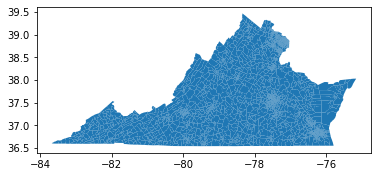

In [308]:
final.plot()

In [ ]:
shp.plot()

- Need to run geom almost equals on joined shapefile
- geom x and y to compare, -- see how many match and dont, of ones that did not match, can see how big or small changes were

In [ ]:
shp_final_merge = pd.merge(shp, final, on = 'unique_id', how = 'inner', suffixes = ['_x', '_y'])

In [ ]:
shp['geometry'].geom_almost_equals(final['geometry'], decimal = 6)

In [ ]:
(set(shp.unique_id) - set(final['unique_id']))

In [ ]:
shp

### Election result comparison:

In [309]:
column_list = ['G18USSDKAI', 'G18USSRSTE', 'G18USSLWAT', 'G18USSOWRI']

In [310]:
final_df_merge = pd.merge(df_with_absentee_reallocated, final, on = 'unique_id_1', how = 'inner', suffixes = ('_x', '_y'))

In [311]:
final_df_merge.dropna()

,Pct,LOCALITY_x,G18USSDKAI_x,G18USSRSTE_x,G18USSLWAT_x,G18USSOWRI_x,COUNTYFP_x,vtdst,unique_id_x,unique_id_1,COUNTYFP_y,LOCALITY_y,VTDST,PRECINCT,G18USSDKAI_y,G18USSRSTE_y,G18USSLWAT_y,G18USSOWRI_y,geometry,unique_id_y
0,101 - Chincoteague,Accomack County,556.611206,994.002907,17.280000,0.000000,001,101,001101,001101,001,Accomack County,000101,Chincoteague,556,994,17,0,"POLYGON Z ((-75.42507 37.89957 0.00000, -75.42...",001101
1,201 - Atlantic,Accomack County,181.727273,458.606491,10.800000,0.000000,001,201,001201,001201,001,Accomack County,000201,Atlantic,182,459,11,0,"POLYGON Z ((-75.59978 37.87664 0.00000, -75.59...",001201
2,202 - Greenbackville,Accomack County,316.594054,576.990958,7.560000,1.142857,001,202,001202,001202,001,Accomack County,000202,Greenbackville,316,577,8,1,"POLYGON Z ((-75.49919 37.93416 0.00000, -75.49...",001202
3,301 - New Church,Accomack County,588.613493,476.737446,10.800000,0.000000,001,301,001301,001301,001,Accomack County,000301,New Church,588,477,11,0,"POLYGON Z ((-75.64987 37.92702 0.00000, -75.64...",001301
4,401 - Bloxom,Accomack County,121.151515,277.296948,4.320000,0.000000,001,401,001401,001401,001,Accomack County,000401,Bloxom,121,277,4,0,"POLYGON Z ((-75.71556 37.87513 0.00000, -75.71...",001401
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2455,401 - Harwoods Mill,York County,966.784659,1484.418188,49.724696,6.129032,199,401,199401,199401,199,York County,000401,HARWOODS MILL,967,1484,50,6,"POLYGON Z ((-76.47686 37.14917 0.00000, -76.47...",199401
2456,402 - Dare,York County,930.071318,1550.224518,37.834008,4.903226,199,402,199402,199402,199,York County,000402,DARE,930,1550,38,5,"POLYGON Z ((-76.46356 37.16058 0.00000, -76.46...",199402
2457,403 - Grafton,York County,566.275479,736.815133,22.700405,1.225806,199,403,199403,199403,199,York County,000403,GRAFTON,566,737,23,1,"POLYGON Z ((-76.48228 37.16839 0.00000, -76.48...",199403
2458,501 - Tabb,York County,1170.376826,1476.866642,57.291498,7.354839,199,501,199501,199501,199,York County,000501,TABB,1170,1477,58,7,"MULTIPOLYGON Z (((-76.42953 37.10608 0.00000, ...",199501


In [312]:
#adapted from PDV training
def sum_checker(df, column_list):
    list_max = 0
    for i in column_list:
        left_sum = df[i+'_x'].sum()
        right_sum = df[i+'_y'].sum()
        if (left_sum == right_sum):
            print('column: ', i, ' have the same sums')
        
        else:
            diff = abs(left_sum - right_sum)
            percent = abs(left_sum - right_sum)/left_sum
            print('column: ', i)
            print('RDH sum is ', str(left_sum))
            print('Partner sum is ', str(right_sum))
            print('their (absolute) difference is ', str(diff))
            print('As a percentage of DF1 this is ', str(round(percent*100,5)) + '%')
            if (percent>list_max):
                list_max = percent
            print('')
    print('The max difference (as a percent of the total of on DF column is: ', str(round(list_max,5)))

In [313]:
sum_checker(final_df_merge, column_list)

column:  G18USSDKAI
RDH sum is  1908232.614472311
Partner sum is  1908233
their (absolute) difference is  0.38552768900990486
As a percentage of DF1 this is  2e-05%

column:  G18USSRSTE
RDH sum is  1373606.5182525432
Partner sum is  1373608
their (absolute) difference is  1.4817474568262696
As a percentage of DF1 this is  0.00011%

column:  G18USSLWAT
RDH sum is  61494.86524163569
Partner sum is  61495
their (absolute) difference is  0.1347583643073449
As a percentage of DF1 this is  0.00022%

column:  G18USSOWRI
RDH sum is  5502.35
Partner sum is  5505
their (absolute) difference is  2.649999999999636
As a percentage of DF1 this is  0.04816%

The max difference (as a percent of the total of on DF column is:  0.00048


**Bc 1500 off**, would be helpful to know largest amount it is off by - is it truly off bc of rounding?

In [314]:
#pulled from sam's pdv training
def validater_row_vect(df, county_column, join_column, column_List):
    matching_rows = 0
    different_rows = 0
    
    county_join_cols = (df[county_column].astype('str') + ' ' + df[join_column].astype('str')).to_numpy()
    
    # it's because before, we were checking that a row was entirely consistent
    # here, we are double checking a lot
    # so, let's just keep one track of the rows that are messed up
    
    wrong_idxs = np.zeros(len(df))
    for i in column_List:
        left_data = df[i + "_x"].to_numpy()
        right_data = df[i + "_y"].to_numpy()
        
        local_idxs = np.where(left_data != right_data)
        wrong_idxs[local_idxs] = 1
        #print("Wrong idxs", wrong_idxs)
        
    # we are close, we get the same result, but are double adding lots of rows
    different_rows += np.sum(wrong_idxs)
    matching_rows += len(df) - different_rows
    
    diff_list = county_join_cols[np.where(wrong_idxs == 1)]
            
    print("There are ", len(df.index)," total rows")
    print(f"{int(different_rows)} of these rows have election result differences")
    print(f"{int(matching_rows)} of these rows are the same")
    print(diff_list)
    print("")

In [315]:
validater_row_vect(final_df_merge, 'COUNTYFP_x', 'unique_id_1', column_list)

There are  2460  total rows
2442 of these rows have election result differences
18 of these rows are the same
['001 001101' '001 001201' '001 001202' ... '199 199403' '199 199501'
 '199 199502']



**Discrepencies likely due to rounding errors, esp since totals were better before I added in rounding**

In [316]:
#From Peter's MO
def validater_row (df, column_List):
    matching_rows = 0
    different_rows = 0
    diff_list=[]
    diff_values = []
    max_diff = 0
    
    for j in range(0,len(df.index)):
        same = True
        for i in column_List:
            left_Data = i + "_x"
            right_Data = i + "_y"
            diff = abs(df.iloc[j][left_Data]-df.iloc[j][right_Data])
            if(diff != 0):
                diff_values.append(abs(diff))
                same = False
                if(np.isnan(diff)):
                    print("NaN value at diff is: ", df.iloc[j]['unique_id_1'])
                if (diff>max_diff):
                    max_diff = diff
                    print("New max diff is: ", str(max_diff))
                    print(df.iloc[j]['unique_id_1'])
        if(same != True):
            different_rows +=1
            diff_list.append(df.iloc[j]['unique_id_1'])
        else:
            matching_rows +=1
    print("There are ", len(df.index)," total rows")
    print(different_rows," of these rows have election result differences")
    print(matching_rows," of these rows are the same")
    print("")
    print("The max difference between any one shared column in a row is: ", max_diff)
    if(len(diff_values)!=0):
        print("The average difference is: ", str(sum(diff_values)/len(diff_values)))
        #add line for % of total vote that difference is
    count_big_diff = len([i for i in diff_values if i > 10])
    print("There are ", str(count_big_diff), "precinct results with a difference greater than 5")
    diff_list.sort()


In [317]:
col_list = column_list
validater_row(final_df_merge ,col_list)

New max diff is:  0.6112064036592528
001101
New max diff is:  0.6134934248141235
001301
New max diff is:  1.0811892510005237
001701
New max diff is:  1.2310101801096351
510108
New max diff is:  1.4821591948764876
019101
New max diff is:  2.0417346896060735
019101
New max diff is:  2.4060027627779164
019203
New max diff is:  2.4867337602927932
019301
New max diff is:  2.9258920402561444
019403
New max diff is:  3.4958828911253477
019505
New max diff is:  3.8243366880146823
019506
New max diff is:  11.948808453730294
550001
New max diff is:  30.665665490101446
550003
New max diff is:  31.257514305132418
550006
New max diff is:  123.56010360494247
059229
New max diff is:  127.74257392918707
153112CD 10)
New max diff is:  157.07154223577777
153212
There are  2460  total rows
2442  of these rows have election result differences
18  of these rows are the same

The max difference between any one shared column in a row is:  157.07154223577777
The average difference is:  2.256914418936348
There

**THE ABOVE** is based on the non-rounded values. Because of the very low average, it shows that the large discrepency in Prince William County is an anomoly among lower differences. 

In [189]:
final_df_merge[final_df_merge['unique_id_1'] == '153212']

,Pct,LOCALITY_x,G18USSDKAI_x,G18USSRSTE_x,G18USSLWAT_x,G18USSOWRI_x,COUNTYFP_x,vtdst,unique_id_x,unique_id_1,COUNTYFP_y,LOCALITY_y,VTDST,PRECINCT,G18USSDKAI_y,G18USSRSTE_y,G18USSLWAT_y,G18USSOWRI_y,geometry,unique_id_y
1798,212 - Yorkshire (CD 10),Prince William County,1654.0,793.0,46.0,12.0,153,212,153212,153212,153,Prince William County,000212,Yorkshire,1811,842,49,12,"POLYGON Z ((-77.47297 38.78839 0.00000, -77.47...",153212


In [ ]:
#Precinct by precinct comparison from pdv training ex
def validater_row(df, county_column, join_column, column_list):
    matching_rows = 0
    different_rows = 0
    diff_list = []
    
    for j in range(0, len(df.index)):
        same = True
        for i in column_list:
            left_data = i + '_x'
            right_data = i + '_y'
            if(df.iloc[j][left_data] - df.iloc[j][right_data] != 0):
                same = False
            if(same != True):
                different_rows += 1
                diff_list.append(str(df.iloc[j][county_column]) + ' ' + str(df.iloc[j][join_column]))
            else:
                matching_rows += 1
        print('There are ', len(df.index), ' total rows')
        print(different_rows," of these rows have election result differences")
        print(matching_rows," of these rows are the same")
        print(diff_list)
        print("")

In [ ]:
validater_row(final_df_merge, 'COUNTYFP_x', 'unique_id_1', column_list)